Team Members：

|Name|Student Number|
|-------|----------|
|Wei Lin|1008696403|
|Xu Chen|999543837 |


## 1. Import libs and install package

In [ ]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import math
import datetime
from datetime import datetime
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import keras as keras
from sklearn.decomposition import PCA
import pywt
from math import log
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.neural_network import MLPRegressor
import seaborn as sns

from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit


## 2. Define Helpful Functions

In [ ]:
def detrendPrice(series):
    # fit linear model
    length = len(series)
    x = np.arange(length)
    y = np.array(series.values)
    # need to add intercept constant
    x_const = sm.add_constant(x)
    model = sm.OLS(y,x_const)
    result = model.fit()
    df = pd.DataFrame(result.params*x_const)
    y_hat = df[0] + df[1]
    # the residuals are the detrended prices
    resid = y-y_hat
    # add minimum necessary to residuals to avoid negative detrended parices
    resid = resid + abs(resid.min() + 1/10*resid.min())
    return resid 

# get data given a column       
def get_data(symbols,price_type,start,end,period = '1d'):
    df = yf.download(symbols,period = period, start=start, end=end)
    return df[f'{price_type}']

# get all data columns returned by yfinance       
def get_all_data(symbols,start,end,period = '1d'):
    df = yf.download(symbols,period = period, start=start, end=end)
    return df

# plot APPL stock data
def plot_stock_data(df, fileName):
  plt.figure(figsize=(24,11))
  for col in df.columns.values:
      plt.subplot(2, 4, np.where(df.columns.values == col)[0]+1)
      df[col].plot()
      plt.ylabel(col)
      plt.xlabel(None)
      plt.title(col + " of APPL Stock")
  plt.savefig(fileName)

# trading strategy and calculate accumulative ROI
def trading(y_pred, y_test):
  y_pred=s2.inverse_transform(y_pred.reshape(-1, 1))
  y_test_copy=y_test.copy()
  y_test_shift=np.concatenate([[[0]],y_test_copy])[:-1]


  pred_pctchange=y_pred/y_test_shift

  pred_pctchange=pd.DataFrame(pred_pctchange,columns=['Pred']).replace([np.inf], np.nan).fillna(0)
  pred_pctchange=pred_pctchange.values

  true_pctchange=pd.DataFrame(y_test,columns=['True']).pct_change().fillna(0)
  true_pctchange=true_pctchange.values

  pred_pctchange
  roi=[]
  len_p=len(y_pred)
  for i in range(len_p):
   if pred_pctchange[i]>=1:
    roi.append(true_pctchange[i,0])
  return_all=1
  for i in roi:
    return_all=return_all*(1+i)

  return (roi, return_all)

## wavelet smoother to denoise
def wavelet_smoother(data):
  db6 = pywt.Wavelet('db6')
  
        # decompose
  coeffs = pywt.wavedec(data, db6)
        # Set high frequency coefficient to zero
  coeffs[len(coeffs)-1] *= 0
  coeffs[len(coeffs)-2] *= 0
        # reconstruct
  meta = pywt.waverec(coeffs, db6)
  return meta

def model_learning_curve(history, fileName):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.savefig(fileName)

def validation_plot(df, y_pred ,y_test, modelName):
    # plot predicted stock price vs real price
    plt.plot(y_test, color = 'blue', label = 'APPL Stock Price')
    plt.plot(y_pred, color = 'green', label = 'Predicted APPL Stock Price')
    plt.title('APPL Stock Price Prediction - ' + modelName)
    plt.xlabel('Time')
    plt.ylabel('APPL Stock Price')
    plt.legend()
    plt.savefig(modelName + ' test and prediction plot.jpg')

    # Plot the data
    train = df[:train_len]
    valid = df[train_len:]
    valid['Predictions'] = y_pred
    # Visualize the data
    plt.figure(figsize=(16,6))
    plt.title('APPL Stock Trend Prediction - ' + modelName)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Close'])
    plt.plot(valid[['Close', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    plt.savefig(modelName + ' test and prediction trend plot.jpg')

def roi_curve(roi):
     plt.plot(roi, color = 'green')
     plt.title('Return over investment')
     plt.xlabel('Trading time', fontsize=18)
     plt.ylabel('Price precentage change', fontsize=18)

In [ ]:
# WhiteRealityCheck.py
def bootstrap(ser):
    ser.dropna(inplace=True)
    arr = np.array(ser.values)
    alpha = .05*100 #significance alpha
    reps = 5000 #how many bootstrapings, 50000 limit if you have 8GB RAM

    percentile = 100-alpha
    ave = np.average(arr) #arithmetic mean

    print("average return %f" %ave)

    #ave = ms.gmean(arr) #geometric mean

    centered_arr = arr-ave
    n = len(centered_arr)
    #constructs 50000 alternative return histories and calculates their theoretical averages
    xb = np.random.choice(centered_arr, (n, reps), replace=True)
    mb = xb.mean(axis=0) #arithmetic mean
    #mb = ms.gmean(mb, axis=0) #geometric mean

    #sorts the 50000 averages
    mb.sort()
    #calculates the 95% conficence interval (two tails) threshold for the theoretical averages
    print(np.percentile(mb, [2.5, 97.5])) 
    threshold = np.percentile(mb, [percentile])[0]


    if ave > threshold:
        print("Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)")
    else:
        print("Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)")

    #count will be the items i that are smaller than ave
    count_vals = 0
    for i in mb:
        count_vals += 1
        if i > ave:
            break
        
    #p is based on the count that are larger than ave so 1-count is needed:
    p = 1-count_vals/len(mb)

    print("p_value:")
    print(p)

## 3. Data preprocessing

### 3.1 Load APPL stock data from yahoo finance

In [ ]:
# Data
stock_list=['AAPL']
start='2016-01-01'
end='2022-08-23'
seq_len=30

data = get_all_data(stock_list,start=start,end = end)
data['GEX'] = get_data(['Gex'],'Close', start=start,end = end)
data=data.fillna(0)
train_len=int(np.ceil(0.7*data.shape[0]))


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
data.to_csv('Data_csv')

### 3.2 Data exploration

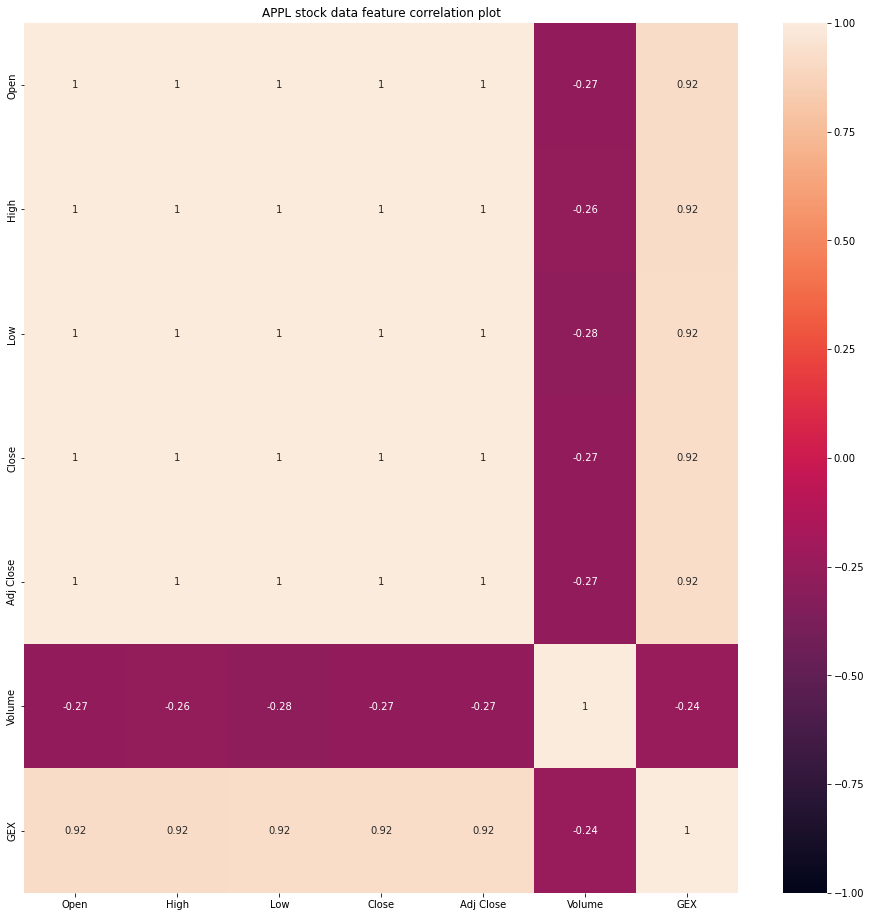

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True);
plt.title('APPL stock data feature correlation plot')
plt.savefig('APPL feature heatmap.jpg')

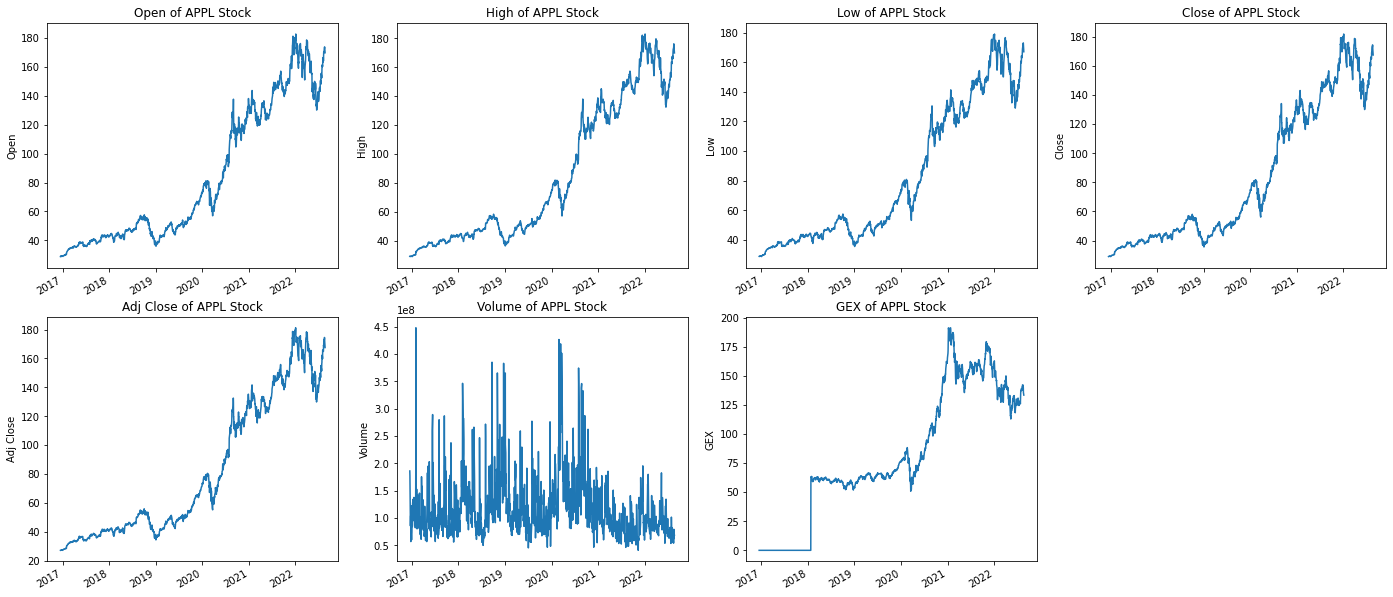

In [ ]:
plot_stock_data(data, 'APPL data graph.jpg')

### 3.3 Denoise using wavelet transformation

In [ ]:
denoise_list = ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume','GEX']
data_denoise=pd.DataFrame()
for i in denoise_list: 
 data_denoise[i]=wavelet_smoother(data[i].values).tolist()
data_denoise

,Open,High,Low,Close,Adj Close,Volume,GEX
0,26.112141,26.623515,25.700479,26.270735,24.090242,2.551516e+08,2.972973e-18
1,25.817417,26.242865,25.406061,25.833634,23.689405,2.569568e+08,2.798451e-18
2,25.307216,25.587496,24.895620,25.089197,23.006762,2.614642e+08,2.627542e-18
3,24.925215,25.106157,24.495989,24.551853,22.514079,2.629425e+08,2.458196e-18
4,24.677190,24.804295,24.217911,24.230419,22.219463,2.630140e+08,2.289785e-18
...,...,...,...,...,...,...,...
1667,172.825769,174.613170,172.055177,173.426069,173.426644,6.619958e+07,1.396221e+02
1668,173.046204,174.682579,172.109559,173.272229,173.265377,6.737898e+07,1.385488e+02
1669,172.622310,173.795446,171.302060,172.161397,172.155497,6.751868e+07,1.371847e+02
1670,171.859992,172.437838,170.067983,170.598639,170.596862,6.736195e+07,1.358290e+02


### 3.4 Detrend price

In [ ]:
# detrench price 
detrend_list = ['Open', 'High', 'Low', 'Close', 'Adj Close']
for i in detrend_list:
  data_denoise[i] = detrendPrice(data_denoise[i]).values
data

,Open,High,Low,Close,Adj Close,Volume,GEX
Date,,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.151495,270597600,0.000000
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.546278,223164000,0.000000
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.085480,273829600,0.000000
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.111164,324377600,0.000000
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.228090,283192000,0.000000
...,...,...,...,...,...,...,...
2022-08-16,172.779999,173.710007,171.660004,173.029999,173.029999,56377100,141.350006
2022-08-17,172.770004,176.149994,172.570007,174.550003,174.550003,79542000,140.100006
2022-08-18,173.750000,174.899994,173.119995,174.149994,174.149994,62290100,139.860001


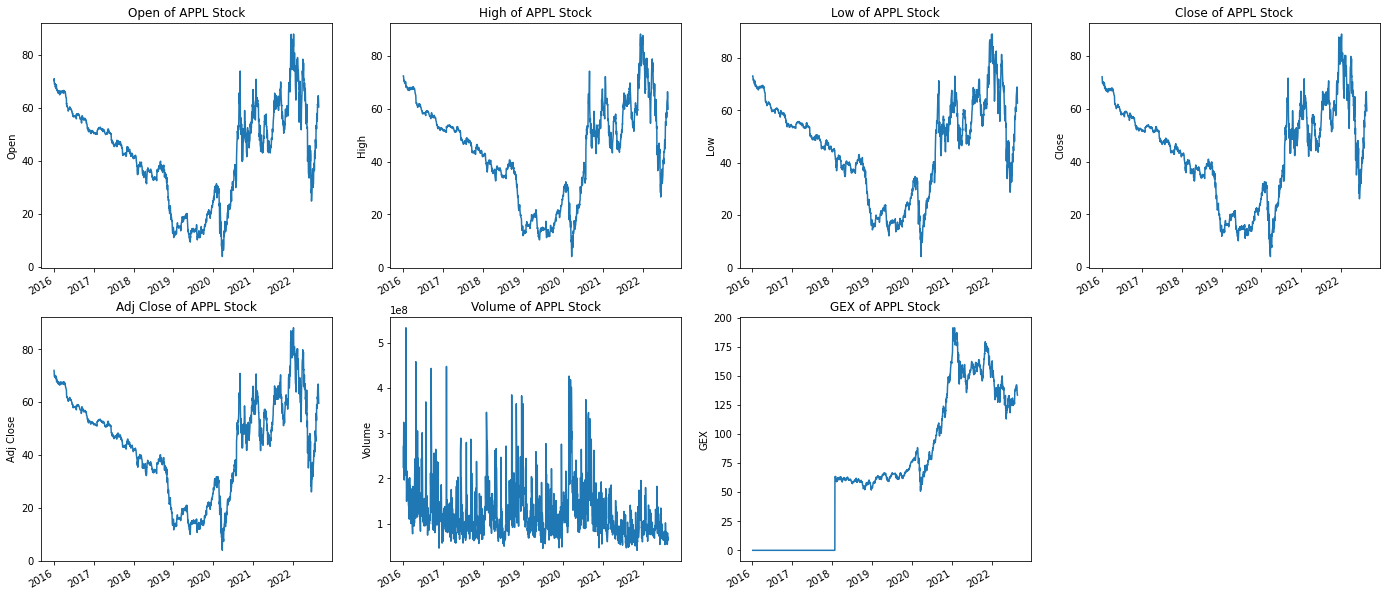

In [ ]:
plot_stock_data(data, 'APPL data graph detrended.jpg')

### 3.5 MinMaxScaler

In [ ]:
s1 = MinMaxScaler(feature_range=(0,1))
s2 = MinMaxScaler(feature_range=(0,1))

train_set = pd.DataFrame(data_denoise.iloc[0:int(train_len), :])
# train_set = pd.DataFrame(data.iloc[0:int(train_len), :])
test_set= pd.DataFrame(data_denoise.iloc[int(train_len)-seq_len:, :])
# test_set= pd.DataFrame(data.iloc[int(train_len)-seq_len:, :])
train_y =  train_set[['Close']]
train_x = train_set.drop(['Close'], axis=1)
test_y = test_set[['Close']]
test_x = test_set.drop(['Close'], axis=1)

scaled_train_x = s1.fit_transform(train_x[train_x.columns])
scaled_test_x = s1.transform(test_x[test_x.columns])
scaled_train_y = s2.fit_transform(train_y)

### 3.6 PCA

In [ ]:
##PCA STANDRADIZE
n1=StandardScaler()
scaled_train_x=n1.fit_transform(scaled_train_x)
scaled_test_x=n1.transform(scaled_test_x)
## Apply pca
pca = PCA(n_components=3) 

pca_x_train = pca.fit_transform(scaled_train_x)
pca_x_test = pca.transform(scaled_test_x)

# Calculate the variance explained by priciple components
print('Variance of each component:', pca.explained_variance_ratio_)
print('\nTotal Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

Variance of each component: [0.77662596 0.16916162 0.0541345 ]

Total Variance Explained: 99.99


### 3.7 Train/test split (70/30)

In [ ]:
# process rolling seq_no target closing price
X_train=[]
y_train=[]
X_test=[]
y_test=[]

y_test = data_denoise.iloc[train_len:, :]['Close']
# y_test = data.iloc[train_len:, :]['Close']
for i in range(seq_len, train_len):
    X_train.append(pca_x_train[i-seq_len:i, :])
    y_train.append(scaled_train_y[i])

for i in range(seq_len, len(test_set)):
    X_test.append(pca_x_test[i-seq_len:i, :])

X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train).reshape(-1,1)
y_test=np.array(y_test).reshape(-1,1)
## Reshape for time_step, input_dim(seq_len), input_size
X_train=np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))
X_test=np.reshape(X_test, (X_test.shape[0], X_train.shape[1], -1))

print(X_train.shape)
print(y_train.shape)

(1140, 30, 3)
(1140, 1)


## 4. Model

In [ ]:
print('Testing data size: ', len(test_set))
print('Training data size: ', len(train_set))

Testing data size:  532
Training data size:  1170


### 4.1 Linear and regression model

In [ ]:
pipe = Pipeline([('classifier' , LinearRegression())])

# Create param grid.
param_grid = [
    {'classifier': [LinearRegression()]},
    {'classifier': [SGDRegressor()],
    'classifier__penalty' : ['l1', 'l2'],
    'classifier__alpha' : [1,0.1,0.01,0.001]},
    {'classifier': [MLPRegressor(random_state=1)],
     'classifier__hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
     'classifier__activation': ['relu', 'tanh'],
     'classifier__alpha': [0.0001, 0.05]}
]

# Create grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, refit=True, scoring='neg_root_mean_squared_error')

# Fit on data

best_clf = clf.fit(X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]), y_train)
y_pred = best_clf.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))
y_pred = s2.inverse_transform(y_pred.reshape(-1, 1))

print(" Results from Grid Search ")
print('\n Model RMSE', np.sqrt(np.mean(((y_pred - y_test) ** 2))))
print("\n The best estimator across ALL searched params:\n",best_clf.best_estimator_)
print("\n The best score across ALL searched params:\n",best_clf.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf.best_params_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

 Results from Grid Search 

 Model RMSE 0.561584618531538

 The best estimator across ALL searched params:
 Pipeline(steps=[('classifier', LinearRegression())])

 The best score across ALL searched params:
 -0.003163208568060531

 The best parameters across ALL searched params:
 {'classifier': LinearRegression()}


#### Linear and regression model evaluation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


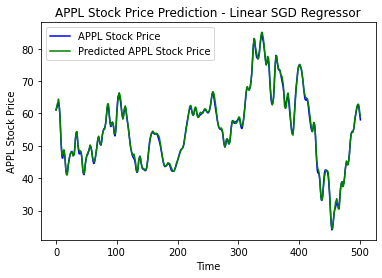

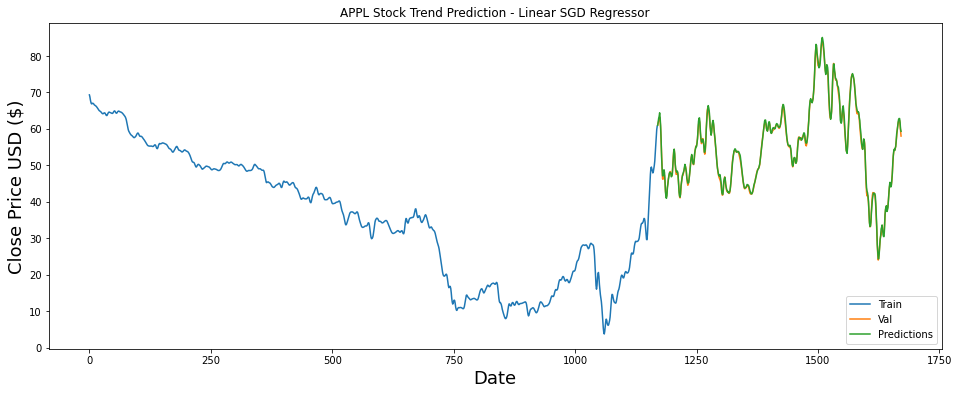

In [ ]:
validation_plot(data_denoise, y_pred, y_test, 'Linear SGD Regressor')

In [ ]:
y_pred=best_clf.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

In [ ]:
roi,all_return=trading(y_pred,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
all_return

70.02950916499049

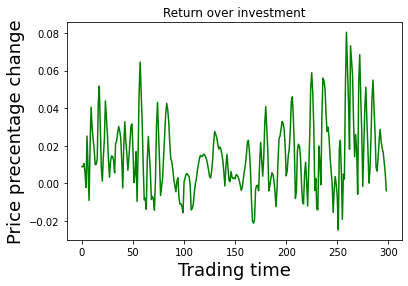

In [ ]:
roi_curve(roi)


In [ ]:
bootstrap(pd.Series(roi))

average return 0.014479
[-0.00208473  0.0021635 ]
Reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is small enough)
p_value:
0.0


### 4.2 RNN (LSTM) model

In [ ]:
# Build RNN LSTM model structure
def create_model(lstm_layer, dense_layer, optimizer='Adam', dropout=0.2):
  model = Sequential()
  model.add(LSTM(lstm_layer[0], return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
  model.add(Dropout(dropout))
  for i in range(1, len(lstm_layer)):
   if i == len(lstm_layer)-1:
       model.add(LSTM(lstm_layer[i], return_sequences=False))
       model.add(Dropout(dropout))
       continue
   model.add(LSTM(lstm_layer[i], return_sequences=True))
   model.add(Dropout(dropout))

  for layer_size in dense_layer:
   model.add(Dense(layer_size, activation='relu'))

  model.add(Dense(1))
  # Compile the model
  model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
  print(model.summary())
  return model

model = KerasRegressor(build_fn=create_model, verbose=0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [ ]:
param_grid = {'lstm_layer': [[256, 128, 64, 32], [128, 64, 32], [64, 32, 16]],
              'dense_layer':[[16], [32], [8]],
              'dropout': [0.2, 0.1],
              'optimizer': ['Adam', 'sgd'],
              'epochs': [40],
              'batch_size': [16, 32, 64]}
ts_cv=TimeSeriesSplit(n_splits=5)
# clf_lstm = GridSearchCV(estimator=model, cv=ts_cv, param_grid=param_grid, scoring='neg_mean_squared_error')
clf_lstm = RandomizedSearchCV(estimator=model, cv=ts_cv, param_distributions=param_grid, scoring='neg_mean_squared_error')
# Fit and tune model
best_clf_lstm = clf_lstm.fit(X_train, y_train)
# best_estimator = clf_lstm.best_estimator_
# print(best_estimator)

y_pred = best_clf_lstm.predict(X_test)
y_pred=y_pred.reshape(-1,1)
y_pred = s2.inverse_transform(y_pred)
print('Model RMSE', np.sqrt(np.mean(((y_pred - y_test) ** 2))))

print(" Results from LSTM Grid Search ")
print("\n The best estimator across ALL searched params:\n",best_clf_lstm.best_estimator_)
print("\n The best score across ALL searched params:\n",best_clf_lstm.best_score_)
print("\n The best parameters across ALL searched params:\n",best_clf_lstm.best_params_)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 256)           266240    
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 64)            49408     
                                                                 
 dropout_2 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                1

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 30, 64)            17408     
                                                                 
 dropout_32 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_33 (LSTM)              (None, 30, 32)            12416     
                                                                 
 dropout_33 (Dropout)        (None, 30, 32)            0         
                                                                 
 lstm_34 (LSTM)              (None, 16)                3136      
                                                                 
 dropout_34 (Dropout)        (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 16)               

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_35 (LSTM)              (None, 30, 256)           266240    
                                                                 
 dropout_35 (Dropout)        (None, 30, 256)           0         
                                                                 
 lstm_36 (LSTM)              (None, 30, 128)           197120    
                                                                 
 dropout_36 (Dropout)        (None, 30, 128)           0         
                                                                 
 lstm_37 (LSTM)              (None, 30, 64)            49408     
                                                                 
 dropout_37 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_38 (LSTM)              (None, 32)              

#### Re-train best LSTM model

In [ ]:
# Best model refit Lstm 
#The best parameters across ALL searched params:{'optimizer': 'Adam', 'lstm_layer': [64, 32, 16], 'epochs': 40, 'dropout': 0.1, 'dense_layer': [8], 'batch_size': 16}
# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.1))
model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(16, return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(8))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=40, validation_split=0.2)

Epoch 1/40
57/57 [==============================] - 9s 54ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 2/40
57/57 [==============================] - 2s 32ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0100 - val_mean_squared_error: 0.0100
Epoch 3/40
57/57 [==============================] - 2s 31ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0090 - val_mean_squared_error: 0.0090
Epoch 4/40
57/57 [==============================] - 2s 31ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0094 - val_mean_squared_error: 0.0094
Epoch 5/40
57/57 [==============================] - 2s 31ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 6/40
57/57 [==============================] - 2s 31ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - val_loss: 0.0054 - val_mean_squared_error: 0.0054
Epoch 7/40
57/57 [================

#### RNN (LSTM) Model Evaluation

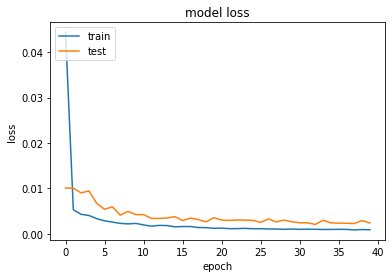

In [ ]:
model_learning_curve(history.history, 'best_lstm_model_learning_curve.jpg')

In [ ]:
y_pred = model.predict(X_test)
y_pred=y_pred.reshape(-1,1)
y_pred = s2.inverse_transform(y_pred)
print('Model RMSE', np.sqrt(np.mean(((y_pred - y_test) ** 2))))

Model RMSE 5.542707974076058


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


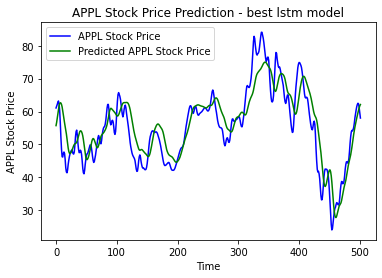

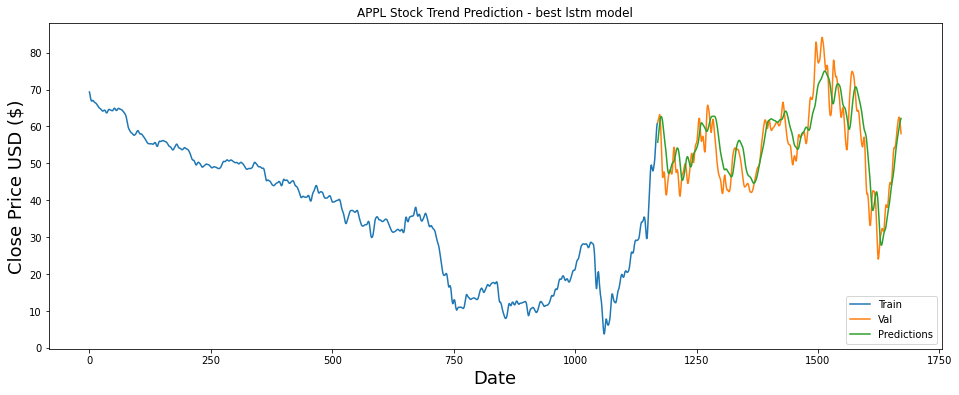

In [ ]:
validation_plot(data_denoise, y_pred, y_test, 'best lstm model')

In [ ]:
roi, re=trading(y_pred,y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in true_divide


In [ ]:
re

0.9499031593415423

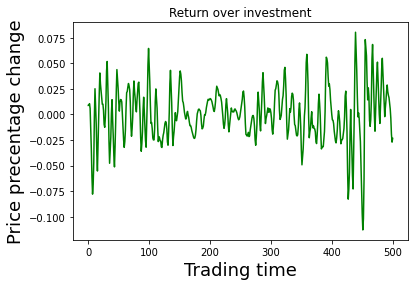

In [ ]:
roi_curve(roi)

In [ ]:
bootstrap(pd.Series(roi))

average return 0.000233
[-0.00231722  0.00222924]
Do not reject Ho = The population distribution of rule returns has an expected value of zero or less (because p_value is not small enough)
p_value:
0.4164


In [ ]:
%%shell
jupyter nbconvert --to html '/content/APS1052_FINAL_PROJECT .ipynb' 

[NbConvertApp] WARNING | pattern '/content/APS1052_FINAL_PROJECT .ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes

CalledProcessError: ignored